<a href="https://colab.research.google.com/github/4may/SuperResolutionSurvey/blob/master/FSRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Super Resolution CNN

## はじめに

FSRCNNとは？？

* 2016年に発表されたSRモデル
* その前に発表されたSRCNNのfast版
* とにかく速い
* citationも300以上とまぁ多い。

2019年のsurveyによると、メジャーなSRモデルの中では最も計算コストが低かった。colab環境がどれだけパフォーマンスが出せるかわからんので、とりあえずsurveyの中で一番速いモデルであるこのFSRCNNを実装してみようと思う。

[このmediumの記事](https://towardsdatascience.com/review-fsrcnn-super-resolution-80ca2ee14da4)が分かりやすそうなので、参考にする。

## SRCNN

fastなやつを考える間に、まずその前モデルであるSRCNNを学ぼう。

ともあれ、アーキテクチャから。

In [0]:
import cv2
import matplotlib.pyplot as plt

In [0]:
def show_image(filepath):
  plt.figure(figsize=(15, 15))
  img = cv2.imread(filepath)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

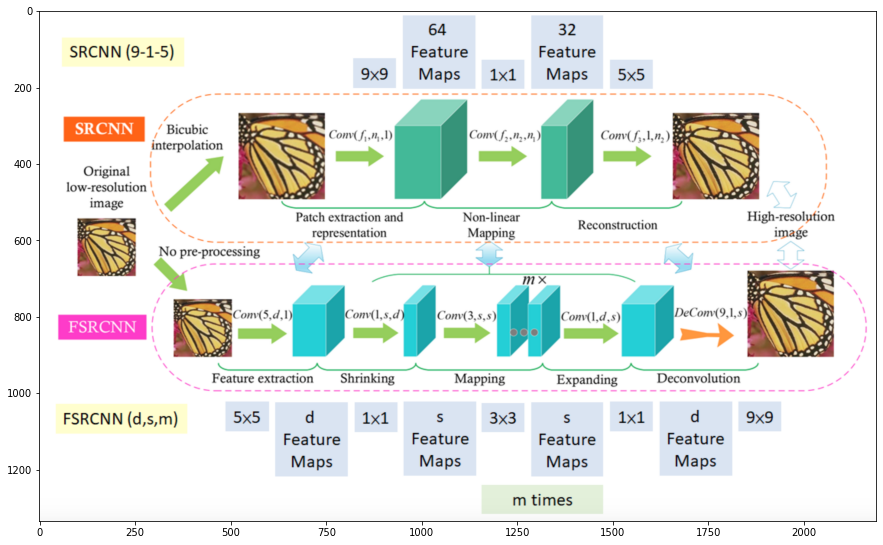

In [8]:
show_image("fsrcnn.png")

なお、Conv(f, n, c)は、f×fサイズのフィルダをn枚使って畳み込み、その時のチャネル数がcであることを意味する。

SRCNNの学習手順は以下のとおり。

1. Bicubic補間を使って、入力画像を所望の画像サイズまでupsamplingする
2. 以下、3層のconvolution layerを使って、画質を向上させる。
  * 9x9
  * 1x1 : 非線形変換。LR画像をHR画像にする。
  * 5x5

SRCNNの計算量は以下の通り。

$O\{(n_1f_1^2+n_1f_2^2n_2+n_2f_3^2)S_{HR}\}$

ただし、$S_{HR}$はHR画像のサイズ。見てわかるように、HR画像のサイズに線形比例して計算量が大きくなる。

## FSRCNN

FSRCNNの処理手順は、以下の5ステップ。

1. Feature Extraction : サイズ5x5フィルタの畳み込み。SRCNNのbicubic補間の代わり。
2. Shrinking : サイズ1x1フィルタの畳み込み。feature mapsの数をdからsに削減する。
3. Non-linear Mapping : サイズ3x3フィルタの畳み込み。非線形変換。SRCNNの1x1フィルタの代わり。m枚まで重ねられる。
4. Expanding : サイズ1x1フィルタの畳み込み。mapsの数をsからdに増やす。
5. Deconvolution : サイズ9x9フィルタの逆畳み込み。HR画像を取得する。

時間計算量は以下の通り。

$O\{(25d+sd+9ms^2+ds+81d)S_{LR}\}$ = $O\{(9ms^2+2sd+106d)S_{LR}\}$

SRCNNとの大きな違いは、$S_{HR}$ではなく$S_{LR}$に依存しているということ。$S_{LR}$ << $S_{HR}$であるため、計算コストはかなり落とせる。

なお、

* 活性化関数：PReLU(Parametric ReLU)関数
* 損失関数：MSE

### 1x1フィルタによる畳み込み

まずは、1x1フィルタを使わない場合の計算量を考える。

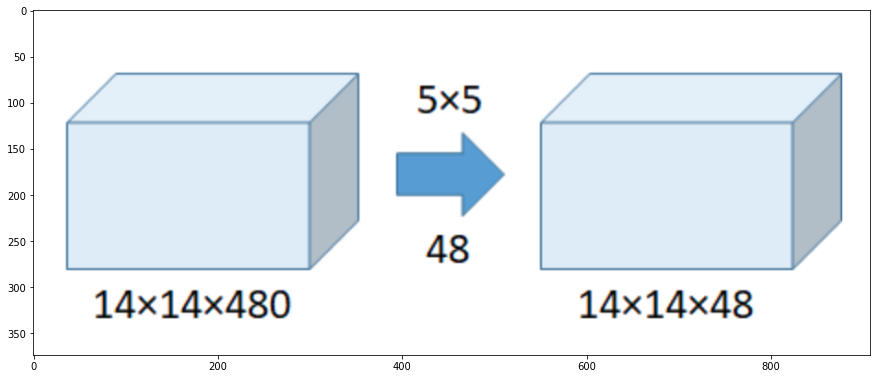

In [10]:
show_image("without_filter.png")

この場合、積和演算の数は、

$(14×14×48)×(5×5×480)=112.9M$

次に、1x1フィルタを使う場合の計算量を求める。

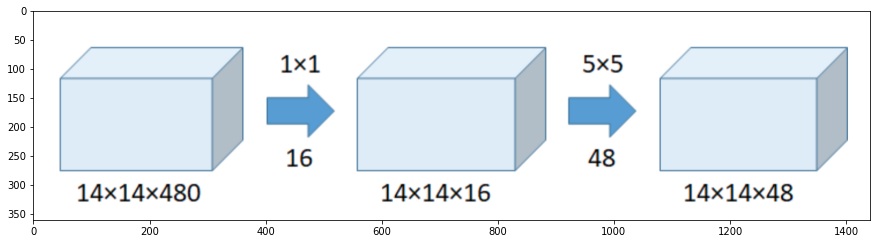

In [11]:
show_image("with_filter.png")

この場合、積和演算(パラメータ)の数は、各畳み込み演算毎のパラメータ数の総和で求める。

一層目：$(14×14×16)+(1×1×480)=1.5M$

二層目：$(14×14×48)+(5×5×16)=3.8M$

合計：$1.5M+3.8M=5.3M$

1x1フィルタを使わない場合のパラメータ数は112.9Mだったので、1x1フィルタを使う場合のパラメータ数は圧倒的に少ない。

### 複数枚の3x3フィルタによる非線形変換

例えば、3x3フィルタが2枚あれば5x5のスペースを満遍なく埋めることができる。

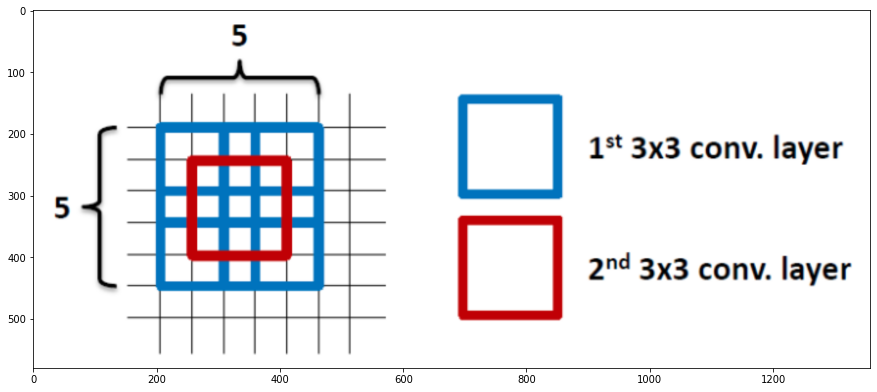

In [12]:
show_image("nonlinear_mapping.png")

5x5のフィルタ1枚を使うよりも、3x3のフィルタ2枚を使う方がパラメータ数的にお得。

* 5x5のフィルタ：$5×5=25$
* 3x3のフィルタ：$3×3+3×3=18$

28%の節約！

ネットワークのパラメータ数は少ない方が速く学習できるし過学習も防ぐことができる。

## 実験

論文中で使われているFSRCNNのパラメータ設定は以下の通り。

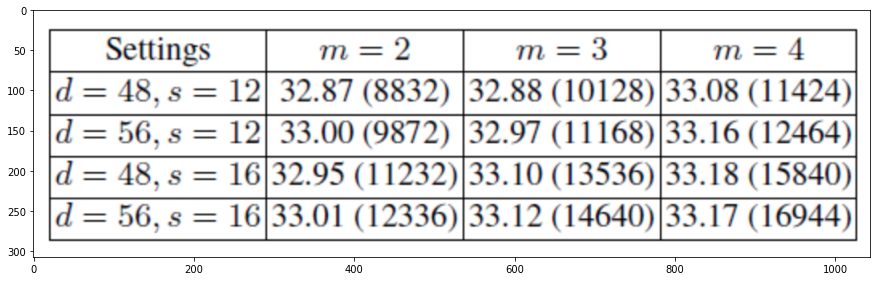

In [14]:
show_image("fsrcnn_parameter.png")

非線形変換フィルタの数mを多くすればするほど、PSNRは大きくなるが、パラメータ数も大きなってしまう。(精度と計算コストのトレードオフ)

論文では、m=4, d=56, s=12を採用することにしている。この時のFSRCNNをFSRCNN(56, 12, 4)とする。

さらに、FSRCNNのスモールバージョンをFSRCNN-s:として、FSRCNN(32, 5, 1)とする。非線形変換フィルタが一枚なので、PSNRは低くなるが計算はめちゃ速い。

#### 実験方法

以下、学習方法について述べる。

1. まず91種類の画像データ([91-image](https://www.kaggle.com/ll01dm/t91-image-dataset))を使って学習する。upscaling factorは3とする
2. さらに、100種類の画像データ([general-100 image](http://riemenschneider.hayko.at/vision/dataset/task.php?did=335))を使ってfine tuningする。upscaling factorは2と4とする。

なお、各画像データに対して、data augmentationする

* scaling:0.9, 0.8, 0.7, 0.6
* rotation:90, 180, 270

#### 実験結果

以下の表に示す。

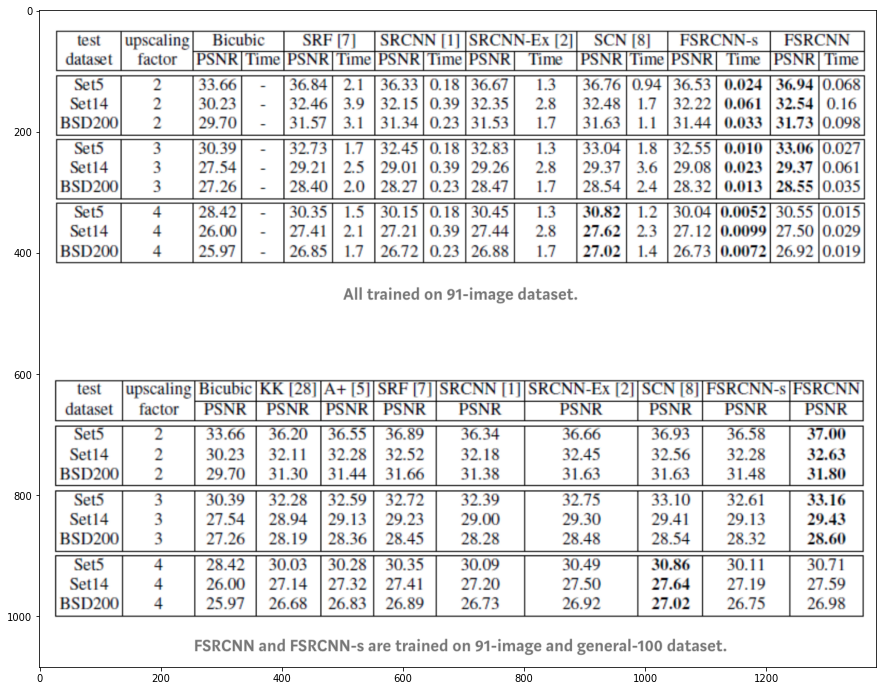

In [15]:
show_image("experimental_result.png")

* upscaling factorが２と３の時は、FSRCNNのPSNRはSRCNNのPSNRより0.xxポイント上回った
* upscaling factorが4の時は、SCNのPSNRがFSRCNNのPSNRを0.xxポイント上回った

## まとめ

* FSRCNNは、以下の仕組みによって高速化を実現している。なお、FSRCNNはSRCNNの5%ほどのパラメータ数で学習できる。
  * SRCNNにおけるLR画像のupscalingを畳み込み演算に置き換えることで、HR画像ではなくLR画像を扱えるようにした
  * 1枚の非線形変換フィルタをより小さなサイズの複数のフィルタに分割することで、パラメータ数を削減した
  * 1x1フィルタの畳み込み層を間にかますことで、パラメータ数を削減した